# Method 2 - Best Ideas High Minus Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
low_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

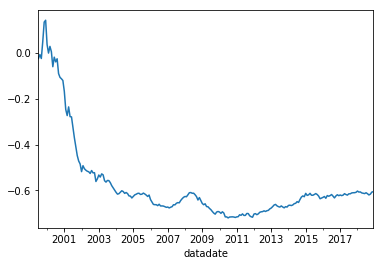

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.143375
2000-12-31   -0.230290
2001-12-31   -0.414201
2002-12-31   -0.126548
2003-12-31   -0.108895
2004-12-31   -0.085904
2005-12-31    0.034925
2006-12-31   -0.141414
2007-12-31    0.134479
2008-12-31   -0.039369
2009-12-31   -0.133654
2010-12-31   -0.084813
2011-12-31    0.003586
2012-12-31    0.128654
2013-12-31    0.025223
2014-12-31    0.138307
2015-12-31   -0.015894
2016-12-31    0.028316
2017-12-31    0.038964
2018-12-31    0.007651
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     13.48
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.97e-10
Time:                        01:45:30   Log-Likelihood:                 550.51
No. Observations:                 234   AIC:                            -1091.
Df Residuals:                     229   BIC:                            -1074.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -2.451      0.015      -0.007      -0.001
mktrf          0.1680      0.043      3.872      0.000       0.083       0.254
me            -0.1574      0.050     -3.119      0.002      -0.257      -0.058
ia            -0.3493      0.077     -4.553      0.000      -0.500      -0.198
roe            0.2463      0.066      3.751      0.000       0.117       0.376
==============================================================================
Omnibus:                        5.145   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                7.152
Skew:                          -0.055   Prob(JB):                       0.0280
Kurtosis:                       3.849   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     10.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.92e-08
Time:                        01:45:30   Log-Likelihood:                 550.51
No. Observations:                 234   AIC:                            -1091.
Df Residuals:                     229   BIC:                            -1074.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -1.827      0.068      -0.008       0.000
mktrf          0.1680      0.063      2.655      0.008       0.044       0.292
me            -0.1574      0.051     -3.094      0.002      -0.257      -0.058
ia            -0.3493      0.097     -3.583      0.000      -0.540      -0.158
roe            0.2463      0.094      2.613      0.009       0.062       0.431
==============================================================================
Omnibus:                        5.145   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                7.152
Skew:                          -0.055   Prob(JB):                       0.0280
Kurtosis:                       3.849   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     14.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.13e-11
Time:                        01:45:30   Log-Likelihood:                 550.51
No. Observations:                 234   AIC:                            -1091.
Df Residuals:                     229   BIC:                            -1074.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.539      0.124      -0.009       0.001
mktrf          0.1680      0.075      2.244      0.025       0.021       0.315
me            -0.1574      0.048     -3.251      0.001      -0.252      -0.063
ia            -0.3493      0.113     -3.096      0.002      -0.570      -0.128
roe            0.2463      0.113      2.174      0.030       0.024       0.468
==============================================================================
Omnibus:                        5.145   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                7.152
Skew:                          -0.055   Prob(JB):                       0.0280
Kurtosis:                       3.849   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     9.105
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.54e-08
Time:                        01:45:30   Log-Likelihood:                 547.07
No. Observations:                 234   AIC:                            -1082.
Df Residuals:                     228   BIC:                            -1061.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.807      0.072      -0.006       0.000
mktrf          0.1077      0.044      2.436      0.016       0.021       0.195
smb           -0.1869      0.058     -3.204      0.002      -0.302      -0.072
hml           -0.1073      0.069     -1.560      0.120      -0.243       0.028
rmw            0.0901      0.078      1.158      0.248      -0.063       0.243
cma           -0.2432      0.099     -2.460      0.015      -0.438      -0.048
==============================================================================
Omnibus:                        7.671   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               11.171
Skew:                          -0.187   Prob(JB):                      0.00375
Kurtosis:                       4.003   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     7.287
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.36e-06
Time:                        01:45:30   Log-Likelihood:                 547.07
No. Observations:                 234   AIC:                            -1082.
Df Residuals:                     228   BIC:                            -1061.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.473      0.141      -0.007       0.001
mktrf          0.1077      0.054      2.007      0.045       0.003       0.213
smb           -0.1869      0.067     -2.789      0.005      -0.318      -0.056
hml           -0.1073      0.077     -1.397      0.162      -0.258       0.043
rmw            0.0901      0.094      0.957      0.339      -0.094       0.275
cma           -0.2432      0.112     -2.169      0.030      -0.463      -0.023
==============================================================================
Omnibus:                        7.671   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               11.171
Skew:                          -0.187   Prob(JB):                      0.00375
Kurtosis:                       4.003   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     12.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.19e-11
Time:                        01:45:30   Log-Likelihood:                 547.07
No. Observations:                 234   AIC:                            -1082.
Df Residuals:                     228   BIC:                            -1061.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.292      0.196      -0.007       0.002
mktrf          0.1077      0.061      1.763      0.078      -0.012       0.227
smb           -0.1869      0.058     -3.221      0.001      -0.301      -0.073
hml           -0.1073      0.083     -1.295      0.195      -0.270       0.055
rmw            0.0901      0.099      0.911      0.363      -0.104       0.284
cma           -0.2432      0.086     -2.833      0.005      -0.411      -0.075
==============================================================================
Omnibus:                        7.671   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               11.171
Skew:                          -0.187   Prob(JB):                      0.00375
Kurtosis:                       4.003   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     11.03
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.35e-08
Time:                        01:45:30   Log-Likelihood:                 546.39
No. Observations:                 234   AIC:                            -1083.
Df Residuals:                     229   BIC:                            -1066.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -2.293      0.023      -0.007      -0.001
mktrf          0.1573      0.041      3.868      0.000       0.077       0.237
smb           -0.2521      0.051     -4.967      0.000      -0.352      -0.152
hml           -0.2007      0.050     -3.980      0.000      -0.300      -0.101
umd            0.0887      0.033      2.680      0.008       0.023       0.154
==============================================================================
Omnibus:                        8.737   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               11.588
Skew:                          -0.272   Prob(JB):                      0.00305
Kurtosis:                       3.945   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     7.778
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.80e-06
Time:                        01:45:30   Log-Likelihood:                 546.39
No. Observations:                 234   AIC:                            -1083.
Df Residuals:                     229   BIC:                            -1066.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -1.921      0.055      -0.007    7.32e-05
mktrf          0.1573      0.062      2.536      0.011       0.036       0.279
smb           -0.2521      0.046     -5.517      0.000      -0.342      -0.163
hml           -0.2007      0.083     -2.410      0.016      -0.364      -0.037
umd            0.0887      0.050      1.778      0.075      -0.009       0.186
==============================================================================
Omnibus:                        8.737   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               11.588
Skew:                          -0.272   Prob(JB):                      0.00305
Kurtosis:                       3.945   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     7.968
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.97e-06
Time:                        01:45:30   Log-Likelihood:                 546.39
No. Observations:                 234   AIC:                            -1083.
Df Residuals:                     229   BIC:                            -1066.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -1.696      0.090      -0.008       0.001
mktrf          0.1573      0.071      2.208      0.027       0.018       0.297
smb           -0.2521      0.046     -5.438      0.000      -0.343      -0.161
hml           -0.2007      0.091     -2.201      0.028      -0.379      -0.022
umd            0.0887      0.049      1.826      0.068      -0.007       0.184
==============================================================================
Omnibus:                        8.737   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               11.588
Skew:                          -0.272   Prob(JB):                      0.00305
Kurtosis:                       3.945   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     14.89
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.84e-10
Time:                        01:45:30   Log-Likelihood:                 272.39
No. Observations:                 120   AIC:                            -534.8
Df Residuals:                     115   BIC:                            -520.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0085      0.002     -3.464      0.001      -0.013      -0.004
mktrf          0.3024      0.066      4.595      0.000       0.172       0.433
me            -0.1012      0.065     -1.556      0.122      -0.230       0.028
ia            -0.4879      0.102     -4.792      0.000      -0.690      -0.286
roe            0.4703      0.090      5.220      0.000       0.292       0.649
==============================================================================
Omnibus:                        3.395   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.191
Skew:                           0.198   Prob(JB):                        0.203
Kurtosis:                       3.694   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     22.21
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.33e-13
Time:                        01:45:30   Log-Likelihood:                 272.39
No. Observations:                 120   AIC:                            -534.8
Df Residuals:                     115   BIC:                            -520.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0085      0.003     -2.792      0.005      -0.014      -0.003
mktrf          0.3024      0.070      4.299      0.000       0.165       0.440
me            -0.1012      0.069     -1.458      0.145      -0.237       0.035
ia            -0.4879      0.088     -5.572      0.000      -0.659      -0.316
roe            0.4703      0.099      4.753      0.000       0.276       0.664
==============================================================================
Omnibus:                        3.395   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.191
Skew:                           0.198   Prob(JB):                        0.203
Kurtosis:                       3.694   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     35.72
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.24e-19
Time:                        01:45:30   Log-Likelihood:                 272.39
No. Observations:                 120   AIC:                            -534.8
Df Residuals:                     115   BIC:                            -520.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0085      0.003     -2.497      0.013      -0.015      -0.002
mktrf          0.3024      0.085      3.550      0.000       0.135       0.469
me            -0.1012      0.077     -1.322      0.186      -0.251       0.049
ia            -0.4879      0.091     -5.338      0.000      -0.667      -0.309
roe            0.4703      0.117      4.021      0.000       0.241       0.700
==============================================================================
Omnibus:                        3.395   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.191
Skew:                           0.198   Prob(JB):                        0.203
Kurtosis:                       3.694   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     8.018
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.66e-06
Time:                        01:45:30   Log-Likelihood:                 265.44
No. Observations:                 120   AIC:                            -518.9
Df Residuals:                     114   BIC:                            -502.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0073      0.003     -2.734      0.007      -0.013      -0.002
mktrf          0.2064      0.074      2.794      0.006       0.060       0.353
smb           -0.1360      0.084     -1.626      0.107      -0.302       0.030
hml           -0.2321      0.103     -2.264      0.025      -0.435      -0.029
rmw            0.2947      0.121      2.438      0.016       0.055       0.534
cma           -0.2696      0.132     -2.036      0.044      -0.532      -0.007
==============================================================================
Omnibus:                        2.118   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.701
Skew:                          -0.118   Prob(JB):                        0.427
Kurtosis:                       3.533   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     14.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.47e-11
Time:                        01:45:30   Log-Likelihood:                 265.44
No. Observations:                 120   AIC:                            -518.9
Df Residuals:                     114   BIC:                            -502.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0073      0.003     -2.271      0.023      -0.014      -0.001
mktrf          0.2064      0.075      2.761      0.006       0.060       0.353
smb           -0.1360      0.100     -1.367      0.172      -0.331       0.059
hml           -0.2321      0.126     -1.846      0.065      -0.479       0.014
rmw            0.2947      0.132      2.240      0.025       0.037       0.553
cma           -0.2696      0.141     -1.915      0.055      -0.546       0.006
==============================================================================
Omnibus:                        2.118   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.701
Skew:                          -0.118   Prob(JB):                        0.427
Kurtosis:                       3.533   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     39.39
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.48e-23
Time:                        01:45:30   Log-Likelihood:                 265.44
No. Observations:                 120   AIC:                            -518.9
Df Residuals:                     114   BIC:                            -502.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0073      0.004     -2.080      0.038      -0.014      -0.000
mktrf          0.2064      0.085      2.437      0.015       0.040       0.372
smb           -0.1360      0.093     -1.460      0.144      -0.319       0.047
hml           -0.2321      0.139     -1.676      0.094      -0.504       0.039
rmw            0.2947      0.138      2.130      0.033       0.023       0.566
cma           -0.2696      0.119     -2.264      0.024      -0.503      -0.036
==============================================================================
Omnibus:                        2.118   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.701
Skew:                          -0.118   Prob(JB):                        0.427
Kurtosis:                       3.533   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     9.918
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.26e-07
Time:                        01:45:30   Log-Likelihood:                 265.14
No. Observations:                 120   AIC:                            -520.3
Df Residuals:                     115   BIC:                            -506.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.003     -2.594      0.011      -0.012      -0.002
mktrf          0.2496      0.062      4.052      0.000       0.128       0.372
smb           -0.3230      0.070     -4.605      0.000      -0.462      -0.184
hml           -0.2467      0.070     -3.512      0.001      -0.386      -0.108
umd            0.1461      0.043      3.372      0.001       0.060       0.232
==============================================================================
Omnibus:                        1.346   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                0.871
Skew:                          -0.124   Prob(JB):                        0.647
Kurtosis:                       3.336   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     10.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-07
Time:                        01:45:30   Log-Likelihood:                 265.14
No. Observations:                 120   AIC:                            -520.3
Df Residuals:                     115   BIC:                            -506.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.003     -2.546      0.011      -0.012      -0.002
mktrf          0.2496      0.067      3.751      0.000       0.119       0.380
smb           -0.3230      0.052     -6.223      0.000      -0.425      -0.221
hml           -0.2467      0.091     -2.697      0.007      -0.426      -0.067
umd            0.1461      0.053      2.738      0.006       0.042       0.251
==============================================================================
Omnibus:                        1.346   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                0.871
Skew:                          -0.124   Prob(JB):                        0.647
Kurtosis:                       3.336   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     10.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-07
Time:                        01:45:30   Log-Likelihood:                 265.14
No. Observations:                 120   AIC:                            -520.3
Df Residuals:                     115   BIC:                            -506.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.003     -2.401      0.016      -0.012      -0.001
mktrf          0.2496      0.069      3.630      0.000       0.115       0.384
smb           -0.3230      0.051     -6.308      0.000      -0.423      -0.223
hml           -0.2467      0.092     -2.694      0.007      -0.426      -0.067
umd            0.1461      0.050      2.897      0.004       0.047       0.245
==============================================================================
Omnibus:                        1.346   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                0.871
Skew:                          -0.124   Prob(JB):                        0.647
Kurtosis:                       3.336   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.288
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.279
Time:                        01:45:30   Log-Likelihood:                 306.32
No. Observations:                 114   AIC:                            -602.6
Df Residuals:                     109   BIC:                            -589.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.407      0.162      -0.001       0.006
mktrf         -0.0255      0.050     -0.515      0.607      -0.124       0.073
me            -0.1376      0.076     -1.799      0.075      -0.289       0.014
ia             0.0085      0.106      0.080      0.936      -0.202       0.219
roe           -0.0342      0.093     -0.367      0.714      -0.219       0.150
==============================================================================
Omnibus:                        2.924   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.982
Skew:                           0.002   Prob(JB):                        0.225
Kurtosis:                       3.792   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.206
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00332
Time:                        01:45:30   Log-Likelihood:                 306.32
No. Observations:                 114   AIC:                            -602.6
Df Residuals:                     109   BIC:                            -589.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.217      0.224      -0.001       0.006
mktrf         -0.0255      0.066     -0.388      0.698      -0.154       0.103
me            -0.1376      0.055     -2.482      0.013      -0.246      -0.029
ia             0.0085      0.072      0.118      0.906      -0.132       0.149
roe           -0.0342      0.079     -0.435      0.664      -0.189       0.120
==============================================================================
Omnibus:                        2.924   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.982
Skew:                           0.002   Prob(JB):                        0.225
Kurtosis:                       3.792   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.830
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00126
Time:                        01:45:30   Log-Likelihood:                 306.32
No. Observations:                 114   AIC:                            -602.6
Df Residuals:                     109   BIC:                            -589.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.137      0.255      -0.002       0.006
mktrf         -0.0255      0.064     -0.397      0.692      -0.152       0.101
me            -0.1376      0.047     -2.910      0.004      -0.230      -0.045
ia             0.0085      0.076      0.111      0.911      -0.141       0.158
roe           -0.0342      0.079     -0.432      0.666      -0.190       0.121
==============================================================================
Omnibus:                        2.924   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.982
Skew:                           0.002   Prob(JB):                        0.225
Kurtosis:                       3.792   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9797
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.434
Time:                        01:45:30   Log-Likelihood:                 306.22
No. Observations:                 114   AIC:                            -600.4
Df Residuals:                     108   BIC:                            -584.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.325      0.188      -0.001       0.006
mktrf         -0.0343      0.048     -0.721      0.472      -0.128       0.060
smb           -0.1008      0.077     -1.308      0.194      -0.254       0.052
hml           -0.0690      0.098     -0.702      0.484      -0.264       0.126
rmw           -0.0075      0.120     -0.063      0.950      -0.246       0.231
cma            0.1009      0.153      0.660      0.511      -0.202       0.404
==============================================================================
Omnibus:                        4.175   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                5.246
Skew:                          -0.040   Prob(JB):                       0.0726
Kurtosis:                       4.048   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     3.417
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00662
Time:                        01:45:30   Log-Likelihood:                 306.22
No. Observations:                 114   AIC:                            -600.4
Df Residuals:                     108   BIC:                            -584.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.170      0.242      -0.002       0.006
mktrf         -0.0343      0.060     -0.574      0.566      -0.151       0.083
smb           -0.1008      0.055     -1.817      0.069      -0.210       0.008
hml           -0.0690      0.087     -0.794      0.427      -0.239       0.101
rmw           -0.0075      0.102     -0.073      0.941      -0.208       0.193
cma            0.1009      0.105      0.960      0.337      -0.105       0.307
==============================================================================
Omnibus:                        4.175   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                5.246
Skew:                          -0.040   Prob(JB):                       0.0726
Kurtosis:                       4.048   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     4.034
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00214
Time:                        01:45:30   Log-Likelihood:                 306.22
No. Observations:                 114   AIC:                            -600.4
Df Residuals:                     108   BIC:                            -584.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.100      0.272      -0.002       0.006
mktrf         -0.0343      0.059     -0.581      0.561      -0.150       0.081
smb           -0.1008      0.046     -2.213      0.027      -0.190      -0.012
hml           -0.0690      0.075     -0.921      0.357      -0.216       0.078
rmw           -0.0075      0.097     -0.078      0.938      -0.197       0.182
cma            0.1009      0.087      1.155      0.248      -0.070       0.272
==============================================================================
Omnibus:                        4.175   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                5.246
Skew:                          -0.040   Prob(JB):                       0.0726
Kurtosis:                       4.048   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.184
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.322
Time:                        01:45:30   Log-Likelihood:                 306.11
No. Observations:                 114   AIC:                            -602.2
Df Residuals:                     109   BIC:                            -588.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.449      0.150      -0.001       0.006
mktrf         -0.0383      0.047     -0.814      0.417      -0.131       0.055
smb           -0.1030      0.073     -1.405      0.163      -0.248       0.042
hml           -0.0431      0.076     -0.571      0.569      -0.193       0.107
umd           -0.0168      0.057     -0.296      0.768      -0.130       0.096
==============================================================================
Omnibus:                        3.862   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                4.478
Skew:                          -0.090   Prob(JB):                        0.107
Kurtosis:                       3.954   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.144
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00365
Time:                        01:45:30   Log-Likelihood:                 306.11
No. Observations:                 114   AIC:                            -602.2
Df Residuals:                     109   BIC:                            -588.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.167      0.243      -0.002       0.007
mktrf         -0.0383      0.069     -0.551      0.582      -0.174       0.098
smb           -0.1030      0.051     -2.030      0.042      -0.202      -0.004
hml           -0.0431      0.080     -0.541      0.589      -0.200       0.113
umd           -0.0168      0.075     -0.224      0.823      -0.164       0.131
==============================================================================
Omnibus:                        3.862   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                4.478
Skew:                          -0.090   Prob(JB):                        0.107
Kurtosis:                       3.954   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.893
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00115
Time:                        01:45:31   Log-Likelihood:                 306.11
No. Observations:                 114   AIC:                            -602.2
Df Residuals:                     109   BIC:                            -588.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.071      0.284      -0.002       0.007
mktrf         -0.0383      0.072     -0.533      0.594      -0.179       0.103
smb           -0.1030      0.043     -2.416      0.016      -0.187      -0.019
hml           -0.0431      0.078     -0.553      0.580      -0.196       0.110
umd           -0.0168      0.079     -0.215      0.830      -0.171       0.137
==============================================================================
Omnibus:                        3.862   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                4.478
Skew:                          -0.090   Prob(JB):                        0.107
Kurtosis:                       3.954   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""